### Imports

In [38]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import numpy as np

### Display Utility Functions

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

### Load Model and Segment Functions

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "facebook/sam-vit-large"
model = SamModel.from_pretrained(
    model_name,
).to(device)
processor = SamProcessor.from_pretrained(model_name)

In [4]:
def get_masks(raw_image, input_points):
    inputs = processor(
        raw_image, 
        input_points=[input_points], 
        return_tensors="pt",     
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
    )
    scores = outputs.iou_scores
    return masks, scores    

### Load Image and Points

In [5]:
img_path = "data/base_image.jpg"
raw_image = Image.open(img_path).convert("RGB")

In [6]:
human_input_points = [[270, 300], [500, 200]]
car_input_points = [[500, 100], [200, 375], [300, 150], [500, 375], [150,300]]

### View Image and Details

(612, 407)


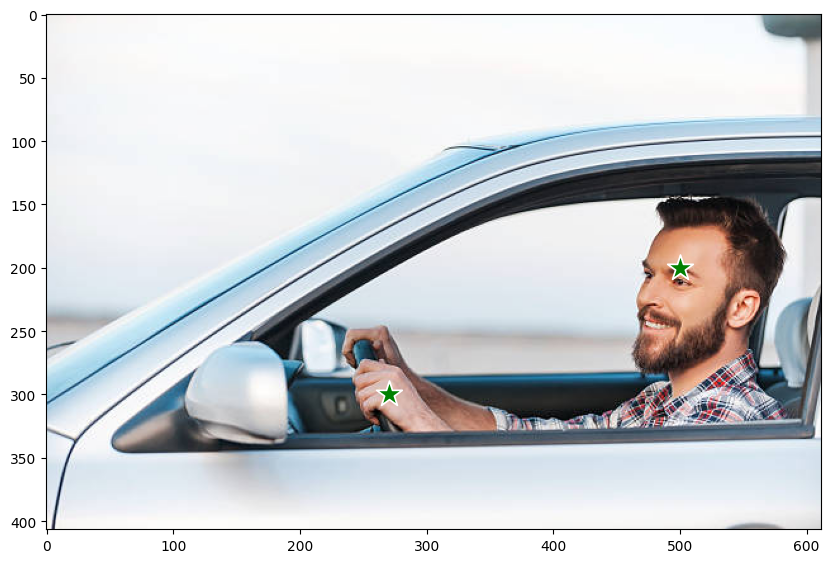

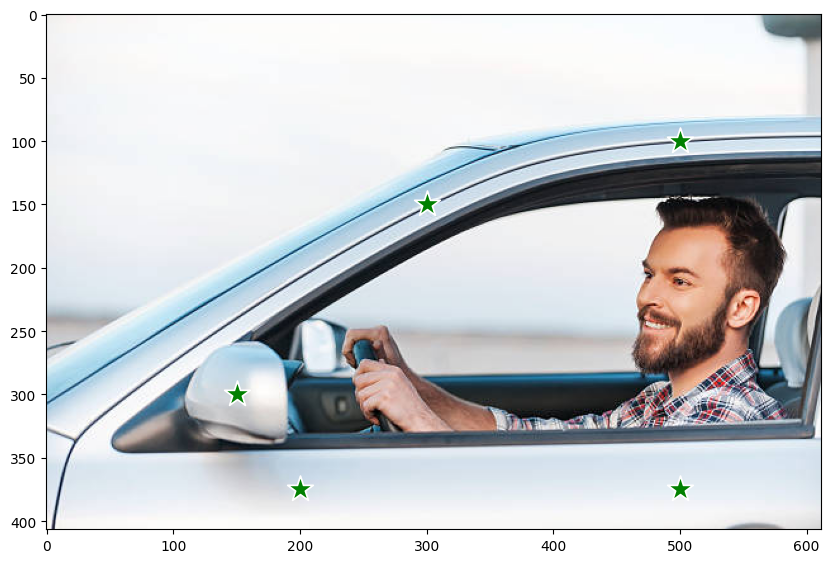

In [7]:
print(raw_image.size)
show_points_on_image(raw_image, human_input_points)
show_points_on_image(raw_image, car_input_points)

### Generate and View Masks

In [8]:
human_masks, human_scores = get_masks(raw_image, human_input_points)
car_masks, car_scores = get_masks(raw_image, car_input_points)

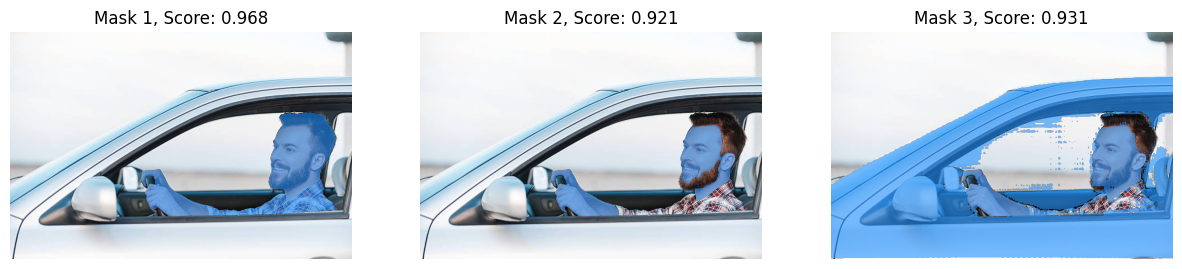

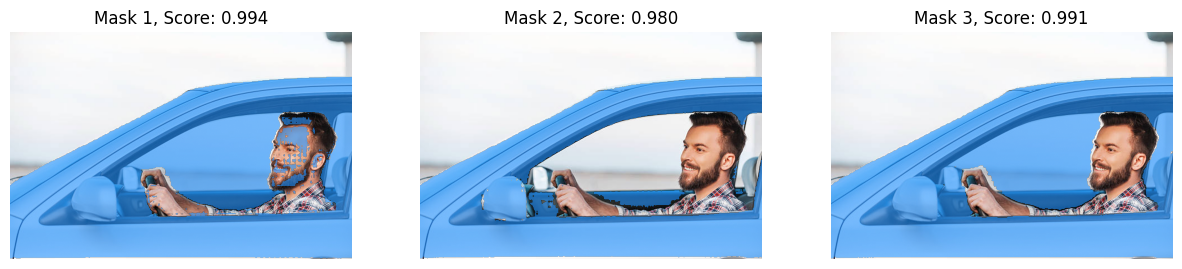

In [9]:
show_masks_on_image(raw_image, human_masks[0], human_scores)
show_masks_on_image(raw_image, car_masks[0], car_scores)

### Choose Selected Masks

In [25]:
human_tensor = human_masks[0][0][0] * 1
human_numpy = human_tensor.cpu().detach().numpy()

car_tensor = car_masks[0][0][1] * 1
car_numpy = car_tensor.cpu().detach().numpy()

### Save Selected Masks

In [39]:
torch.save(human_tensor, "data/human_mask.pt")
torch.save(car_tensor, "data/car_mask.pt")
np.save("data/human_mask.npy", human_numpy)
np.save("data/car_mask.npy", car_numpy)
